# Group 41 Project Report

## Maternal Health Data and Health Risk Level

In [21]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("kknn")
library("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [4]:
mat_health_risk <- read_csv("https://raw.githubusercontent.com/aaronardenma/dsci-100-2023w1-group-41/main/Maternal_Health_Risk_Data_Set.csv")

Rows: 1014 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): RiskLevel
dbl (6): Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
set.seed(1) 

mat_health_risk_split <- initial_split(mat_health_risk, prop = 0.75, strata = RiskLevel)  
health_train <- training(mat_health_risk_split)   
health_test <- testing(mat_health_risk_split)


In [7]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

health_recipe <- recipe(RiskLevel ~ ., data = health_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

health_fit <- workflow() |>
      add_recipe(health_recipe) |>
      add_model(knn_tune) |>
      fit(data = health_train)

health_vfold <- vfold_cv(health_train, v = 5, strata = RiskLevel)

knn_results <- workflow() |>
          add_recipe(health_recipe) |>
          add_model(knn_tune) |>
          tune_grid(resamples = health_vfold, grid = 10) |>
          collect_metrics()

Warning message:
“tune samples were requested but there were 760 rows in the data. 755 will be used.”


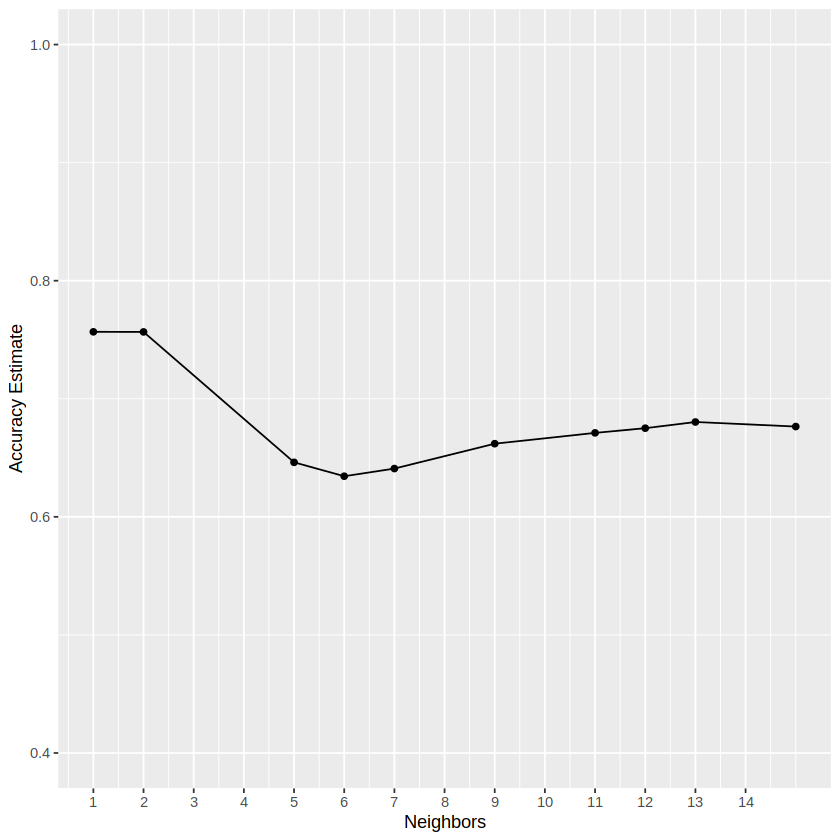

In [8]:
accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis


accuracy_versus_k

In [23]:
health_test_predictions <- predict(health_fit, health_test) |>
      bind_cols(health_test)

health_test_predictions

health_prediction_accuracy <- health_test_predictions |>
                            metrics(truth = RiskLevel, estimate = .pred_class)

health_prediction_accuracy

.pred_class,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
low risk,29,90,70,8,100,80,high risk
low risk,30,140,85,7,98,70,high risk
low risk,35,85,60,11,102,86,high risk
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
low risk,55,140,80,7.2,101,76,high risk
low risk,25,120,90,12.0,101,80,high risk
low risk,43,120,90,18.0,98,70,high risk


ERROR: [1m[33mError[39m in `metric_set()`:[22m
[33m![39m Failed to compute `rmse()`.
[1mCaused by error in `dplyr::summarise()`:[22m
[1m[22m[36mℹ[39m In argument: `.estimate = metric_fn(truth = RiskLevel, estimate =
  .pred_class, na_rm = na_rm)`.
[1mCaused by error in `validate_class()`:[22m
[33m![39m `truth` should be a numeric but a character was supplied.
